In [32]:
# Importación de bibliotecas necesarias
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from PIL import Image
import pandas as pd
import numpy as np
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import seaborn as sns
import optuna 
from optuna.visualization import plot_param_importances, plot_optimization_history

In [33]:
# Configuración del dispositivo (GPU si está disponible, sino CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
# Definición de rutas de archivos y carga de metadatos
csv_file_path = 'Proyecto/poi_dataset.csv'
images_dir = 'Proyecto/data_main/data_main'
metadata = pd.read_csv(csv_file_path)

              tier  locationLon  locationLat          xps        Visits  \
count  1569.000000  1569.000000  1569.000000  1569.000000   1569.000000   
mean      1.541109    -1.132337    39.900141   750.382409  10011.943276   
std       0.637677    22.733401     9.662134   228.319854      5.456808   
min       1.000000  -121.951049   -62.940930     0.000000  10001.000000   
25%       1.000000    -3.725292    40.411754   600.000000  10008.000000   
50%       1.000000    -3.699140    40.421738   700.000000  10011.000000   
75%       2.000000    -3.673348    40.472458  1000.000000  10015.000000   
max       4.000000   158.333118    65.706572  1000.000000  10038.000000   

              Likes      Dislikes    Bookmarks  
count   1569.000000   1569.000000  1569.000000  
mean    3623.908222   2526.305927   973.261950  
std     4817.879374   2225.543360  1453.333948  
min      100.000000     52.000000    50.000000  
25%      464.000000    937.000000   116.000000  
50%     1434.000000   2718.000

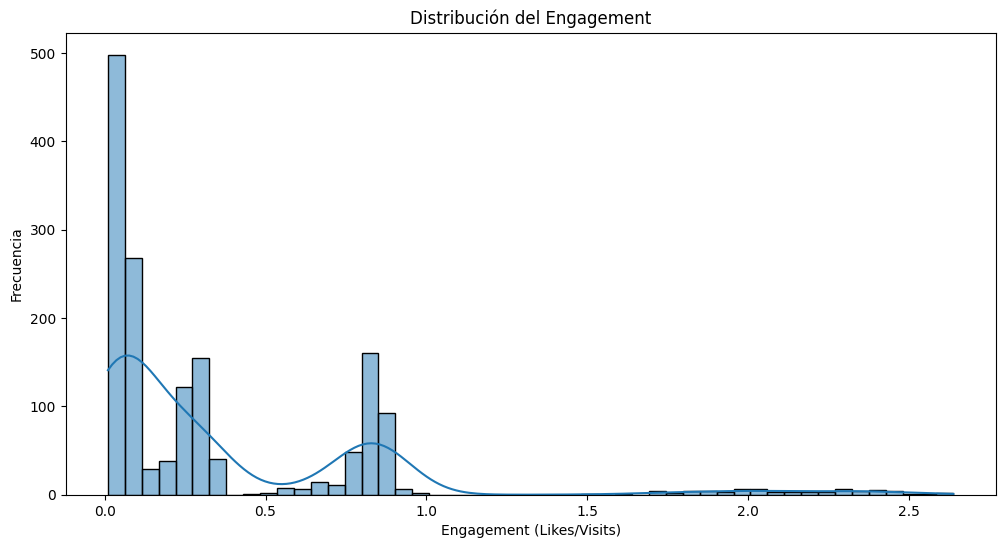

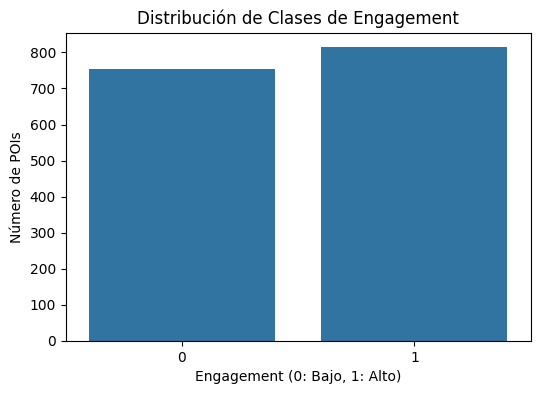

In [35]:
def exploratory_data_analysis(metadata):
    print(metadata.describe())  # Estadísticas descriptivas

    # Histograma de engagement
    plt.figure(figsize=(12, 6))
    sns.histplot(metadata['Likes'] / (metadata['Visits'] + 1e-5), bins=50, kde=True)
    plt.title('Distribución del Engagement')
    plt.xlabel('Engagement (Likes/Visits)')
    plt.ylabel('Frecuencia')
    plt.show()

    # Conteo de clases (engagement alto/bajo)
    plt.figure(figsize=(6, 4))
    sns.countplot(x=(metadata['Likes'] / (metadata['Visits'] + 1e-5) > 0.1).astype(int))
    plt.title('Distribución de Clases de Engagement')
    plt.xlabel('Engagement (0: Bajo, 1: Alto)')
    plt.ylabel('Número de POIs')
    plt.show()

# Realizar análisis exploratorio
exploratory_data_analysis(metadata)

In [36]:
# Crear etiqueta de engagement
metadata['engagement'] = (metadata['Likes'] / (metadata['Visits'] + 1e-5) > 0.1).astype(int)

# Codificación de variables categóricas
metadata = pd.get_dummies(metadata, columns=['tier'], prefix='tier')

In [37]:
# División de datos en conjuntos de entrenamiento, validación y prueba
train_data, test_data = train_test_split(metadata, test_size=0.2, stratify=metadata['engagement'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, stratify=train_data['engagement'], random_state=42)

In [38]:
# Definición de transformaciones para las imágenes
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [39]:
# Definición de dataset personalizado
class POIDataset(Dataset):
    def __init__(self, metadata, images_dir, transform=None):
        self.metadata = metadata
        self.images_dir = images_dir
        self.transform = transform
        self.scaler = StandardScaler()
        self.metadata[['locationLat', 'locationLon', 'xps']] = self.scaler.fit_transform(self.metadata[['locationLat', 'locationLon', 'xps']])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        metadata_features = row[['locationLat', 'locationLon', 'xps'] + [col for col in self.metadata.columns if col.startswith('tier_')]].values.astype(np.float32)
        label = row['engagement']
        img_path = os.path.join(self.images_dir, row['main_image_path'])
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            image = Image.new('RGB', (224, 224), color=(0, 0, 0))
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(metadata_features), torch.tensor(label, dtype=torch.float32)

In [40]:
# Implementación de balance de clases
class_counts = train_data['engagement'].value_counts().to_list()
weights = 1. / torch.tensor(class_counts, dtype=torch.float)
samples_weights = weights[train_data['engagement'].values]
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

In [41]:
# Creación de datasets y dataloaders
train_dataset = POIDataset(train_data, images_dir, transform=train_transform)
val_dataset = POIDataset(val_data, images_dir, transform=val_test_transform)
test_dataset = POIDataset(test_data, images_dir, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
# Definición del modelo combinado
class CombinedModel(nn.Module):
    def __init__(self, num_metadata_features, dropout):
        super(CombinedModel, self).__init__()

        # Inicializar EfficientNet y ResNet pre-entrenados
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Reemplazar las capas fully connected con Identity
        self.efficientnet._fc = nn.Identity()
        self.resnet.fc = nn.Identity()

        # Congelar todas las capas de EfficientNet y ResNet
        for param in self.efficientnet.parameters():
            param.requires_grad = False
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Descongelar las últimas capas convolucionales
        for param in self.efficientnet._conv_head.parameters():
            param.requires_grad = True
        for param in self.resnet.layer4.parameters():
            param.requires_grad = True

         # Capa para procesar metadatos
        self.metadata_fc = nn.Sequential(
            nn.Linear(num_metadata_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

         # Capas fully connected finales
        self.fc = nn.Sequential(
            nn.Linear(1280 + 512 + 128, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x_img, x_metadata):
        # Procesar imágenes a través de EfficientNet y ResNet
        efficientnet_out = self.efficientnet(x_img)
        resnet_out = self.resnet(x_img)

         # Procesar metadatos
        metadata_out = self.metadata_fc(x_metadata)

        # Combinar todas las características
        combined = torch.cat((efficientnet_out, resnet_out, metadata_out), dim=1)

        # Pasar por las capas fully connected finales
        return self.fc(combined)

# Implementación de Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


In [43]:
# Función de entrenamiento
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, early_stopping):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        for images, metadata, labels in train_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, metadata).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_loss /= len(train_loader)
        train_acc = correct_train / total_train

        # Validación
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for images, metadata, labels in val_loader:
                images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
                outputs = model(images, metadata).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc = correct_val / total_val

        # Guardar métricas
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Early Stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, train_accs, val_accs

In [44]:
# Función de evaluación
def evaluate_model(model, test_loader):
    model.eval()
    test_predictions, test_labels = [], []
    with torch.no_grad():
        for images, metadata, labels in test_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata).squeeze()
            test_predictions.extend((outputs > 0.5).cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    test_f1 = f1_score(test_labels, test_predictions)
    test_precision = precision_score(test_labels, test_predictions)
    test_recall = recall_score(test_labels, test_predictions)
    test_accuracy = accuracy_score(test_labels, test_predictions)
    print(f"Test Accuracy: {test_accuracy:.4f}, F1-score: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    return test_accuracy

In [49]:
# Función objetivo para optimización con Optuna
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    num_epochs = trial.suggest_int("num_epochs", 5, 20)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)

    model = CombinedModel(num_metadata_features=7, dropout=dropout).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    early_stopping = EarlyStopping(patience=5, verbose=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, early_stopping)
    accuracy = evaluate_model(model, val_loader)
    return accuracy

In [50]:
# Creación y optimización del estudio con Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Visualización de la optimización
plot_optimization_history(study)
plot_param_importances(study)



[I 2025-01-28 21:35:03,028] A new study created in memory with name: no-name-3b76be83-3757-48fe-9833-0bb65a7affc1


Loaded pretrained weights for efficientnet-b0
Epoch 1/11, Train Loss: 8.3234, Train Acc: 0.5175, Val Loss: 1.1285, Val Acc: 0.5191
Validation loss decreased (inf --> 1.128499). Saving model ...
Epoch 2/11, Train Loss: 0.7841, Train Acc: 0.4920, Val Loss: 1.1750, Val Acc: 0.5127
Epoch 3/11, Train Loss: 0.7087, Train Acc: 0.5324, Val Loss: 1.0491, Val Acc: 0.5096
Validation loss decreased (1.128499 --> 1.049103). Saving model ...
Epoch 4/11, Train Loss: 0.6910, Train Acc: 0.5675, Val Loss: 0.7110, Val Acc: 0.4777
Validation loss decreased (1.049103 --> 0.711045). Saving model ...
Epoch 5/11, Train Loss: 0.6784, Train Acc: 0.5792, Val Loss: 0.7303, Val Acc: 0.4713
Epoch 6/11, Train Loss: 0.6691, Train Acc: 0.6015, Val Loss: 0.7033, Val Acc: 0.4682
Validation loss decreased (0.711045 --> 0.703340). Saving model ...
Epoch 7/11, Train Loss: 0.6759, Train Acc: 0.5877, Val Loss: 0.7080, Val Acc: 0.4554
Epoch 8/11, Train Loss: 0.6540, Train Acc: 0.6217, Val Loss: 0.6668, Val Acc: 0.6146
Validat

[I 2025-01-28 21:36:14,847] Trial 0 finished with value: 0.6146496815286624 and parameters: {'lr': 0.008777186548342693, 'dropout': 0.2683740352963143, 'num_epochs': 11, 'batch_size': 64, 'weight_decay': 0.00018571008765295242}. Best is trial 0 with value: 0.6146496815286624.


Test Accuracy: 0.6146, F1-score: 0.6033, Precision: 0.6479, Recall: 0.5644
Loaded pretrained weights for efficientnet-b0
Epoch 1/15, Train Loss: 0.6936, Train Acc: 0.5239, Val Loss: 0.6898, Val Acc: 0.5191
Validation loss decreased (inf --> 0.689752). Saving model ...
Epoch 2/15, Train Loss: 0.6882, Train Acc: 0.5526, Val Loss: 0.6887, Val Acc: 0.5191
Validation loss decreased (0.689752 --> 0.688673). Saving model ...
Epoch 3/15, Train Loss: 0.6843, Train Acc: 0.5367, Val Loss: 0.6818, Val Acc: 0.5191
Validation loss decreased (0.688673 --> 0.681832). Saving model ...
Epoch 4/15, Train Loss: 0.6777, Train Acc: 0.5707, Val Loss: 0.6788, Val Acc: 0.5255
Validation loss decreased (0.681832 --> 0.678783). Saving model ...
Epoch 5/15, Train Loss: 0.6732, Train Acc: 0.5675, Val Loss: 0.6707, Val Acc: 0.5350
Validation loss decreased (0.678783 --> 0.670686). Saving model ...
Epoch 6/15, Train Loss: 0.6845, Train Acc: 0.5611, Val Loss: 0.6648, Val Acc: 0.6083
Validation loss decreased (0.67068

[I 2025-01-28 21:37:52,257] Trial 1 finished with value: 0.5955414012738853 and parameters: {'lr': 0.00016706818838662223, 'dropout': 0.34066656902307957, 'num_epochs': 15, 'batch_size': 64, 'weight_decay': 0.0006008769076021958}. Best is trial 0 with value: 0.6146496815286624.


Test Accuracy: 0.5955, F1-score: 0.6443, Precision: 0.5928, Recall: 0.7055
Loaded pretrained weights for efficientnet-b0
Epoch 1/15, Train Loss: 1.0023, Train Acc: 0.4963, Val Loss: 2.4901, Val Acc: 0.5191
Validation loss decreased (inf --> 2.490091). Saving model ...
Epoch 2/15, Train Loss: 0.7500, Train Acc: 0.5526, Val Loss: 0.7019, Val Acc: 0.4777
Validation loss decreased (2.490091 --> 0.701934). Saving model ...
Epoch 3/15, Train Loss: 0.7546, Train Acc: 0.4910, Val Loss: 3.8064, Val Acc: 0.5191
Epoch 4/15, Train Loss: 0.7566, Train Acc: 0.5101, Val Loss: 0.6897, Val Acc: 0.5191
Validation loss decreased (0.701934 --> 0.689666). Saving model ...
Epoch 5/15, Train Loss: 0.7365, Train Acc: 0.5399, Val Loss: 0.7839, Val Acc: 0.4809
Epoch 6/15, Train Loss: 0.7315, Train Acc: 0.4931, Val Loss: 0.7264, Val Acc: 0.5191
Epoch 7/15, Train Loss: 0.7350, Train Acc: 0.4931, Val Loss: 0.7419, Val Acc: 0.5191
Epoch 8/15, Train Loss: 0.7362, Train Acc: 0.5112, Val Loss: 0.7810, Val Acc: 0.5191


[I 2025-01-28 21:38:52,437] Trial 2 finished with value: 0.5191082802547771 and parameters: {'lr': 0.0073764132842927075, 'dropout': 0.3941650851133701, 'num_epochs': 15, 'batch_size': 16, 'weight_decay': 0.005335176897108983}. Best is trial 0 with value: 0.6146496815286624.


Test Accuracy: 0.5191, F1-score: 0.6834, Precision: 0.5191, Recall: 1.0000
Loaded pretrained weights for efficientnet-b0
Epoch 1/7, Train Loss: 2.1687, Train Acc: 0.5335, Val Loss: 0.7213, Val Acc: 0.5255
Validation loss decreased (inf --> 0.721269). Saving model ...
Epoch 2/7, Train Loss: 0.6854, Train Acc: 0.5643, Val Loss: 0.6714, Val Acc: 0.6146
Validation loss decreased (0.721269 --> 0.671438). Saving model ...
Epoch 3/7, Train Loss: 0.6860, Train Acc: 0.5537, Val Loss: 0.6858, Val Acc: 0.6019
Epoch 4/7, Train Loss: 0.6588, Train Acc: 0.6206, Val Loss: 0.6757, Val Acc: 0.5955
Epoch 5/7, Train Loss: 0.6640, Train Acc: 0.5739, Val Loss: 0.6687, Val Acc: 0.6051
Validation loss decreased (0.671438 --> 0.668658). Saving model ...
Epoch 6/7, Train Loss: 0.6901, Train Acc: 0.5313, Val Loss: 0.6745, Val Acc: 0.5828
Epoch 7/7, Train Loss: 0.6860, Train Acc: 0.5409, Val Loss: 0.6779, Val Acc: 0.6115


[I 2025-01-28 21:39:38,395] Trial 3 finished with value: 0.6114649681528662 and parameters: {'lr': 0.005842959663839087, 'dropout': 0.3171195741972185, 'num_epochs': 7, 'batch_size': 16, 'weight_decay': 3.553339310953763e-05}. Best is trial 0 with value: 0.6146496815286624.


Test Accuracy: 0.6115, F1-score: 0.5547, Precision: 0.6847, Recall: 0.4663
Loaded pretrained weights for efficientnet-b0
Epoch 1/14, Train Loss: 0.6879, Train Acc: 0.5484, Val Loss: 0.6937, Val Acc: 0.5191
Validation loss decreased (inf --> 0.693669). Saving model ...
Epoch 2/14, Train Loss: 0.6890, Train Acc: 0.5473, Val Loss: 0.6861, Val Acc: 0.5191
Validation loss decreased (0.693669 --> 0.686129). Saving model ...
Epoch 3/14, Train Loss: 0.6832, Train Acc: 0.5526, Val Loss: 0.6880, Val Acc: 0.5191
Epoch 4/14, Train Loss: 0.6845, Train Acc: 0.5558, Val Loss: 0.6841, Val Acc: 0.5318
Validation loss decreased (0.686129 --> 0.684103). Saving model ...
Epoch 5/14, Train Loss: 0.6877, Train Acc: 0.5239, Val Loss: 0.6766, Val Acc: 0.5924
Validation loss decreased (0.684103 --> 0.676610). Saving model ...
Epoch 6/14, Train Loss: 0.6843, Train Acc: 0.5579, Val Loss: 0.6849, Val Acc: 0.5191
Epoch 7/14, Train Loss: 0.6804, Train Acc: 0.5494, Val Loss: 0.6792, Val Acc: 0.5255
Epoch 8/14, Train

[I 2025-01-28 21:41:07,298] Trial 4 finished with value: 0.589171974522293 and parameters: {'lr': 4.700237521807726e-05, 'dropout': 0.3891449583328943, 'num_epochs': 14, 'batch_size': 32, 'weight_decay': 0.001175449754539949}. Best is trial 0 with value: 0.6146496815286624.


Test Accuracy: 0.5892, F1-score: 0.6239, Precision: 0.5944, Recall: 0.6564
Loaded pretrained weights for efficientnet-b0
Epoch 1/13, Train Loss: 0.6999, Train Acc: 0.5239, Val Loss: 0.6838, Val Acc: 0.5382
Validation loss decreased (inf --> 0.683795). Saving model ...
Epoch 2/13, Train Loss: 0.6882, Train Acc: 0.5399, Val Loss: 0.6774, Val Acc: 0.5955
Validation loss decreased (0.683795 --> 0.677364). Saving model ...
Epoch 3/13, Train Loss: 0.6878, Train Acc: 0.5473, Val Loss: 0.6796, Val Acc: 0.5255
Epoch 4/13, Train Loss: 0.6797, Train Acc: 0.5760, Val Loss: 0.6795, Val Acc: 0.5382
Epoch 5/13, Train Loss: 0.6845, Train Acc: 0.5430, Val Loss: 0.6698, Val Acc: 0.6115
Validation loss decreased (0.677364 --> 0.669753). Saving model ...
Epoch 6/13, Train Loss: 0.6776, Train Acc: 0.5930, Val Loss: 0.6689, Val Acc: 0.5955
Validation loss decreased (0.669753 --> 0.668874). Saving model ...
Epoch 7/13, Train Loss: 0.6763, Train Acc: 0.5781, Val Loss: 0.6678, Val Acc: 0.5955
Validation loss d

c:\Users\pauci\miniconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-01-28 21:42:31,560] Trial 5 finished with value: 0.48089171974522293 and parameters: {'lr': 6.891308241124487e-05, 'dropout': 0.37955161121543257, 'num_epochs': 13, 'batch_size': 16, 'weight_decay': 0.00013024911497268435}. Best is trial 0 with value: 0.6146496815286624.


Test Accuracy: 0.4809, F1-score: 0.0000, Precision: 0.0000, Recall: 0.0000
Loaded pretrained weights for efficientnet-b0
Epoch 1/8, Train Loss: 0.6967, Train Acc: 0.5027, Val Loss: 0.6901, Val Acc: 0.5191
Validation loss decreased (inf --> 0.690074). Saving model ...
Epoch 2/8, Train Loss: 0.6928, Train Acc: 0.5207, Val Loss: 0.6892, Val Acc: 0.5191
Validation loss decreased (0.690074 --> 0.689230). Saving model ...
Epoch 3/8, Train Loss: 0.6884, Train Acc: 0.5441, Val Loss: 0.6877, Val Acc: 0.5350
Validation loss decreased (0.689230 --> 0.687744). Saving model ...
Epoch 4/8, Train Loss: 0.6886, Train Acc: 0.5579, Val Loss: 0.6881, Val Acc: 0.5191
Epoch 5/8, Train Loss: 0.6869, Train Acc: 0.5462, Val Loss: 0.6865, Val Acc: 0.5191
Validation loss decreased (0.687744 --> 0.686514). Saving model ...
Epoch 6/8, Train Loss: 0.6851, Train Acc: 0.5505, Val Loss: 0.6849, Val Acc: 0.5255
Validation loss decreased (0.686514 --> 0.684889). Saving model ...
Epoch 7/8, Train Loss: 0.6859, Train Acc

[I 2025-01-28 21:43:24,453] Trial 6 finished with value: 0.5191082802547771 and parameters: {'lr': 1.1613074006158552e-05, 'dropout': 0.21498806702872353, 'num_epochs': 8, 'batch_size': 16, 'weight_decay': 0.008389506123436958}. Best is trial 0 with value: 0.6146496815286624.


Test Accuracy: 0.5191, F1-score: 0.6834, Precision: 0.5191, Recall: 1.0000
Loaded pretrained weights for efficientnet-b0
Epoch 1/15, Train Loss: 0.8497, Train Acc: 0.5101, Val Loss: 0.6909, Val Acc: 0.4904
Validation loss decreased (inf --> 0.690878). Saving model ...
Epoch 2/15, Train Loss: 0.6629, Train Acc: 0.6004, Val Loss: 0.6857, Val Acc: 0.6115
Validation loss decreased (0.690878 --> 0.685710). Saving model ...
Epoch 3/15, Train Loss: 0.6922, Train Acc: 0.5792, Val Loss: 0.6712, Val Acc: 0.6115
Validation loss decreased (0.685710 --> 0.671186). Saving model ...
Epoch 4/15, Train Loss: 0.6811, Train Acc: 0.5824, Val Loss: 0.6631, Val Acc: 0.6115
Validation loss decreased (0.671186 --> 0.663124). Saving model ...
Epoch 5/15, Train Loss: 0.6933, Train Acc: 0.5569, Val Loss: 0.6770, Val Acc: 0.5191
Epoch 6/15, Train Loss: 0.6893, Train Acc: 0.5643, Val Loss: 0.6642, Val Acc: 0.6115
Epoch 7/15, Train Loss: 0.6801, Train Acc: 0.5962, Val Loss: 0.7958, Val Acc: 0.5191
Epoch 8/15, Train

[I 2025-01-28 21:44:22,958] Trial 7 finished with value: 0.5191082802547771 and parameters: {'lr': 0.00501954351865936, 'dropout': 0.3633497173237987, 'num_epochs': 15, 'batch_size': 16, 'weight_decay': 0.00010437083668283186}. Best is trial 0 with value: 0.6146496815286624.


Test Accuracy: 0.5191, F1-score: 0.6834, Precision: 0.5191, Recall: 1.0000
Loaded pretrained weights for efficientnet-b0
Epoch 1/16, Train Loss: 0.6922, Train Acc: 0.5409, Val Loss: 0.6879, Val Acc: 0.5191
Validation loss decreased (inf --> 0.687908). Saving model ...
Epoch 2/16, Train Loss: 0.6959, Train Acc: 0.5282, Val Loss: 0.6864, Val Acc: 0.5191
Validation loss decreased (0.687908 --> 0.686417). Saving model ...
Epoch 3/16, Train Loss: 0.6894, Train Acc: 0.5430, Val Loss: 0.6792, Val Acc: 0.6115
Validation loss decreased (0.686417 --> 0.679206). Saving model ...
Epoch 4/16, Train Loss: 0.6869, Train Acc: 0.5505, Val Loss: 0.6759, Val Acc: 0.6115
Validation loss decreased (0.679206 --> 0.675866). Saving model ...
Epoch 5/16, Train Loss: 0.6880, Train Acc: 0.5420, Val Loss: 0.6777, Val Acc: 0.5255
Epoch 6/16, Train Loss: 0.6880, Train Acc: 0.5547, Val Loss: 0.6723, Val Acc: 0.5955
Validation loss decreased (0.675866 --> 0.672319). Saving model ...
Epoch 7/16, Train Loss: 0.6775, Tr

[I 2025-01-28 21:45:40,858] Trial 8 finished with value: 0.5191082802547771 and parameters: {'lr': 5.398043000367602e-05, 'dropout': 0.4293980425119718, 'num_epochs': 16, 'batch_size': 16, 'weight_decay': 0.0001617152343518199}. Best is trial 0 with value: 0.6146496815286624.


Test Accuracy: 0.5191, F1-score: 0.6834, Precision: 0.5191, Recall: 1.0000
Loaded pretrained weights for efficientnet-b0
Epoch 1/7, Train Loss: 22.3197, Train Acc: 0.5260, Val Loss: 1.0829, Val Acc: 0.5191
Validation loss decreased (inf --> 1.082890). Saving model ...
Epoch 2/7, Train Loss: 1.1854, Train Acc: 0.5133, Val Loss: 0.7267, Val Acc: 0.4809
Validation loss decreased (1.082890 --> 0.726717). Saving model ...
Epoch 3/7, Train Loss: 0.7371, Train Acc: 0.5345, Val Loss: 0.6868, Val Acc: 0.5191
Validation loss decreased (0.726717 --> 0.686786). Saving model ...
Epoch 4/7, Train Loss: 0.7058, Train Acc: 0.5515, Val Loss: 0.6812, Val Acc: 0.5191
Validation loss decreased (0.686786 --> 0.681165). Saving model ...
Epoch 5/7, Train Loss: 0.6935, Train Acc: 0.5505, Val Loss: 0.7012, Val Acc: 0.5191
Epoch 6/7, Train Loss: 0.7049, Train Acc: 0.5260, Val Loss: 0.7029, Val Acc: 0.5191
Epoch 7/7, Train Loss: 0.7013, Train Acc: 0.5728, Val Loss: 1.2968, Val Acc: 0.4809


c:\Users\pauci\miniconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-01-28 21:46:27,524] Trial 9 finished with value: 0.48089171974522293 and parameters: {'lr': 0.008173925842966745, 'dropout': 0.3098076531243852, 'num_epochs': 7, 'batch_size': 64, 'weight_decay': 0.004370978841712797}. Best is trial 0 with value: 0.6146496815286624.


Test Accuracy: 0.4809, F1-score: 0.0000, Precision: 0.0000, Recall: 0.0000


In [51]:
# Imprimimos los mejores hiperparámetros

print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print("Best Hyperparameters:", study.best_params)

Best trial:
Value:  0.6146496815286624
Params: 
    lr: 0.008777186548342693
    dropout: 0.2683740352963143
    num_epochs: 11
    batch_size: 64
    weight_decay: 0.00018571008765295242
Best Hyperparameters: {'lr': 0.008777186548342693, 'dropout': 0.2683740352963143, 'num_epochs': 11, 'batch_size': 64, 'weight_decay': 0.00018571008765295242}


In [53]:
# Entrenar modelo final con los mejores hiperparámetros
best_params = study.best_params
num_metadata_features = len(train_dataset[0][1])
final_model = CombinedModel(num_metadata_features=num_metadata_features, dropout=best_params['dropout']).to(device)
final_criterion = nn.BCELoss()
final_optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
final_early_stopping = EarlyStopping(patience=10, verbose=True)

final_train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], sampler=sampler)
final_val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

train_losses, val_losses, train_accs, val_accs = train_model(final_model, final_train_loader, final_val_loader, final_criterion, final_optimizer, best_params['num_epochs'], final_early_stopping)

Loaded pretrained weights for efficientnet-b0
Epoch 1/11, Train Loss: 42.5770, Train Acc: 0.5377, Val Loss: 48.1573, Val Acc: 0.5191
Validation loss decreased (inf --> 48.157327). Saving model ...
Epoch 2/11, Train Loss: 46.4769, Train Acc: 0.5335, Val Loss: 48.1573, Val Acc: 0.5191
Validation loss decreased (48.157327 --> 48.157327). Saving model ...
Epoch 3/11, Train Loss: 45.5556, Train Acc: 0.5420, Val Loss: 4.8075, Val Acc: 0.5191
Validation loss decreased (48.157327 --> 4.807481). Saving model ...
Epoch 4/11, Train Loss: 46.0440, Train Acc: 0.5388, Val Loss: 2.0866, Val Acc: 0.5191
Validation loss decreased (4.807481 --> 2.086637). Saving model ...
Epoch 5/11, Train Loss: 46.2805, Train Acc: 0.5377, Val Loss: 48.1573, Val Acc: 0.5191
Epoch 6/11, Train Loss: 47.2134, Train Acc: 0.5260, Val Loss: 48.1573, Val Acc: 0.5191
Epoch 7/11, Train Loss: 1.4559, Train Acc: 0.5048, Val Loss: 0.7044, Val Acc: 0.4904
Validation loss decreased (2.086637 --> 0.704385). Saving model ...
Epoch 8/11

In [54]:
# Evaluar modelo final
final_accuracy = evaluate_model(final_model, test_loader)
print(f"Final Test Accuracy: {final_accuracy:.4f}")

Test Accuracy: 0.5191, F1-score: 0.6834, Precision: 0.5191, Recall: 1.0000
Final Test Accuracy: 0.5191


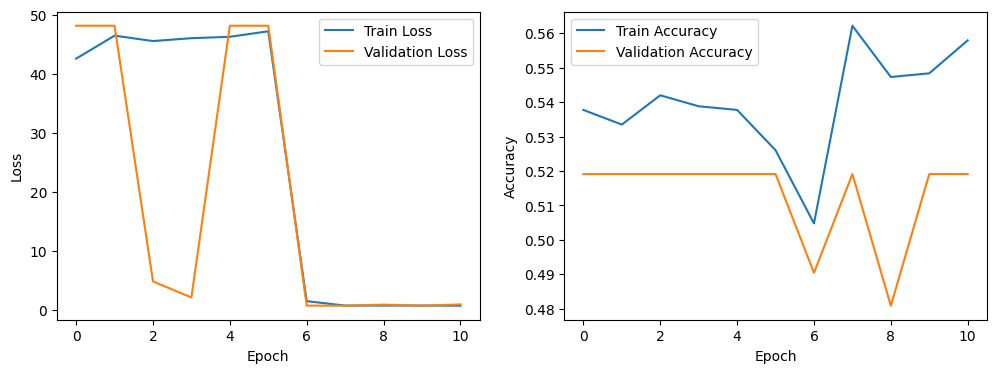

In [55]:
# Visualizar resultados
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()